  # Apply encoder to morphological profiles to get latent space representations :

# Setup

In [2]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
# import shutil
# import getpass
# import yaml
# import hydra
# from hydra import initialize, initialize_config_module, initialize_config_dir, compose
# from omegaconf import OmegaConf
# from typing import Dict, List, Tuple
# from scipy.sparse import csr_matrix
# from tqdm import tqdm
# import wandb

import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ./src
insert ../..
['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']


In [4]:
# import snnl.utils as utils
# from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle

In [9]:
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as sps

import sklearn.metrics as skm
import sklearn.utils.random as skr
from scipy.spatial.distance import pdist, squareform, euclidean

# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
# Models
from xgboost import XGBClassifier, XGBRegressor

import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder

# K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set,
# and its prediction is computed with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
from sklearn.model_selection._split import check_cv

from sklearn.pipeline import Pipeline

# Make a scorer from a performance metric or loss function. This factory function wraps scoring
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score,
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).
from sklearn.metrics import make_scorer

# regression matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# classification metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
from sklearn.preprocessing import StandardScaler


In [7]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}  ")


2024-08-06 21:41:02,346 - __main__ - INFO: -  Excution started : 2024_08_06_21:41:02 
2024-08-06 21:41:02,347 - __main__ - INFO: -  Pytorch version  : 2.2.2
2024-08-06 21:41:02,347 - __main__ - INFO: -  Scipy version    : 1.12.0  		 Numpy version : 1.26.4
2024-08-06 21:41:02,348 - __main__ - INFO: -  Pandas version: 2.2.1  


## Helper routines

In [10]:
sample_idxs = skr.sample_without_replacement(n_population=100, n_samples= 10 )

In [ ]:
rng = np.random.default_rng()

In [16]:
indxs = rng.choice(100, [10,10], replace = False)
indxs

array([[28, 46, 91, 72, 13, 77, 89,  1,  6,  2],
       [20,  8, 97, 70, 60,  7, 27,  0, 57, 63],
       [96, 33, 98,  5, 56, 42, 50, 90, 22, 79],
       [14, 68, 17, 51, 52, 32, 19, 80, 87, 78],
       [47, 83, 21, 26, 54, 93, 94, 31, 29,  4],
       [43, 24, 92, 67, 45, 62, 35, 36, 99, 37],
       [88, 11, 39, 95, 85, 10, 65, 82, 74, 49],
       [18, 59, 12, 76, 53, 40, 16, 44, 15, 55],
       [69, 38, 61, 75, 58, 73, 71, 81, 84, 48],
       [ 3,  9, 30, 25, 23, 66, 41, 64, 34, 86]])

In [435]:
# model selection (hyperparameter tuning)

def model_selection(model, params_grid, X, y,
                    scoring = None, 
                    cv=5, n_jobs=6, pre_dispatch = None,
                    GridSearch = True, n_iter=20,
                    refit = True, verbose = 0):
    """
    return the refitted model on the whole train data
    input:
    -----
    model:          model to be grid searched
    params_grid:    dictionary of hyperparms to grid search
    X, y:           obvious
    scoring:        scoring Strategy to evaluate the performance of the cross-validated model on the test set.
    cv:             cross-validation fold, integer specifies the number of folds in a (Stratified)KFold,
                    stratified is used if the estimator is a classifier and y is either binary or multiclass
    n_iter          Number of parameter settings that are sampled in RandomizedSearchCV.
                    n_iter trades off runtime vs quality of the solution.
    refit:          Refit an estimator using the best found parameters on the whole dataset.
    """
    print(f" verbose is {verbose}")
    if verbose > 0:
        print(f" params_grid: {params_grid}")
        print(f" scoring    : {scoring}     cv:  {cv}   n_jobs: {n_jobs}   gridsearch: {GridSearch}    n_iter: {n_iter}   refit: {refit}   ")
    if pre_dispatch is None:
        pre_dispatch = n_jobs
    if GridSearch :
        model_train = GridSearchCV(model, params_grid, 
                                   cv=cv, n_jobs=n_jobs,
                                   scoring = scoring, 
                                   pre_dispatch = pre_dispatch,
                                   refit = refit, verbose = verbose)
    else:
        model_train = RandomizedSearchCV(model, param_distributions = params_grid, 
                                         cv=cv, n_jobs=n_jobs, 
                                         n_iter = n_iter,
                                         scoring=scoring,
                                         pre_dispatch = pre_dispatch,
                                         refit = refit, verbose = verbose)

    model_train.fit(X, y)

    print("Best parameters set found on development set:", model_train.best_params_ )
    print("Best score:", model_train.best_score_ )

    print("Grid scores on development set:")
    print()
    means = model_train.cv_results_['mean_test_score']
    stds = model_train.cv_results_['std_test_score']


    for mean, std, params in zip(means, stds, model_train.cv_results_['params']):
        print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
    return model_train


In [634]:
def balance_datasets(X,y, ratio = 2, verbose = False):
    y = y.astype(np.uint8)
    neg_idxs = np.nonzero([y == 0])[1]
    pos_idxs = np.nonzero([y == 1])[1]
    pos_idxs = np.array(pos_idxs)
    # print(f"\n # Pos rows: {len(pos_idxs)}   # Neg rows: {len(neg_idxs)}  Total: {len(pos_idxs)+ len(neg_idxs)}")
    # print(f" # Pos compounds: {len(pos_idxs)//3}   # Neg compounds: {len(neg_idxs)//3}  total: {(len(pos_idxs) + len(neg_idxs))//3}")
    # print(f"\n pos indexes - len: {len(pos_idxs)}")
    # print( pos_idxs[:50])
    # print( pos_idxs[-50:])
    # print(f"\n neg indexes - len: {len(neg_idxs)}")
    # print(neg_idxs[:50])
    # print(neg_idxs[-50:])
    
    stepped_pos_idxs = [x for x in pos_idxs if x % 3 == 0]
    stepped_neg_idxs = [x for x in neg_idxs if x % 3 == 0]
    stepped_neg_idxs = np.array(stepped_neg_idxs)
    pos_counts = len(stepped_pos_idxs)
    neg_counts = len(stepped_neg_idxs)
    
    if verbose:
        print(f"\n # Pos counts: {pos_counts}    # Neg counts: {neg_counts}   Total: {pos_counts+neg_counts}")
        print(f"\n pos indexes - len: {pos_counts}")
        print(stepped_pos_idxs[:25])
        print(stepped_pos_idxs[-25:])
        print(f"\n neg indexes - len: {neg_counts}")
        print(stepped_neg_idxs[:25])
        print(stepped_neg_idxs[-25:])
        print()
    num_neg_samples = ratio * pos_counts
    
    print(f"\n Take {pos_counts} samples from total of {pos_counts} negative training samples")
    print(f" Take {num_neg_samples} samples from total of {neg_counts} negative training samples")
    sample_idxs = skr.sample_without_replacement(n_population=neg_counts, n_samples= num_neg_samples, )
    sample_idxs.sort()
    neg_sample_idxs = stepped_neg_idxs[sample_idxs]
    if verbose:
        print(f"\n Sample indxs - len: {len(sample_idxs)}")
        print(f" {sample_idxs[:20]}")
        print(f" {sample_idxs[-20:]}")
        print(f"\n neg_sample_idxs: {len(neg_sample_idxs)}")
        print(f"{neg_sample_idxs[:20]}")
        print(f"{neg_sample_idxs[-20:]}")
        print()
        print(neg_sample_idxs[:20])
        print(neg_sample_idxs[:20]+1)
        print(neg_sample_idxs[:20]+2)
    
    neg_sample_idxs_3 = np.concatenate((neg_sample_idxs, neg_sample_idxs+1, neg_sample_idxs+2))
    neg_sample_idxs_3.sort()
    if verbose:
        print(f"\n pos_sample_idxs_3: {len(pos_idxs)}")
        print(f" [:20] :{pos_idxs[:20]}")
        print(f" [-20:] {pos_idxs[-20:]}")
        print(f"\n neg_sample_idxs_3: {len(neg_sample_idxs_3)}")
        print(f" [:20] :{neg_sample_idxs_3[:20]}")
        print(f" [-20:] {neg_sample_idxs_3[-20:]}")
    
    balanced_ds_idxs = np.concatenate((pos_idxs, neg_sample_idxs_3))

    bal_X = X[balanced_ds_idxs]
    bal_y = y[balanced_ds_idxs]

    print(f"\n Balanced Dataset: # pos samples: {len(pos_idxs)}    # Neg samples: {len(neg_sample_idxs_3)}  Total len: {len(balanced_ds_idxs)}")   
    print(f"\n X :  Min: {bal_X.min():.4f}    Max: {bal_X.max():.4f}   Mean: {bal_X.mean():.4f}  Std: {bal_X.std():.4f}")
    print(f" y :  Min: {bal_y.min():.4f}    Max: {bal_y.max():.4f}   Mean: {bal_y.mean():.4f}  Std: {bal_y.std():.4f}")
    return bal_X,bal_y

In [610]:
def label_counts(input_list = None, title = None, label = None):
    if input_list is None:
        input_list = [(title, label)]

    for (ttl, lbl) in input_list:
        bcnt = np.bincount(lbl.astype(np.int64))
        print(f" {ttl}")
        print(f" Total samples: {bcnt.sum()}")
        print(f" Label 0: {bcnt[0]:7,d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
        print(f" Label 1: {bcnt[1]:7,d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
        print("")
        
def compute_metrics(true, pred):
    test_accuracy = skm.accuracy_score(true, pred)
    # precision : tp / (tp+fp)
    precision, recall, f1, support = skm.precision_recall_fscore_support(true, pred, average='binary', zero_division=0)
    label_count = len(true)
    print(f" Accuracy: {test_accuracy:.5f}     Precision: {precision:.5f}     Recall: {recall:.5f}     F1: {f1:.5f} \n"
          f"\n True + labels:        {true.sum():6.0f}     ratio to total:  {true.sum()/label_count:.5f}"
          f"\n Predicted + labels:   {pred.sum():6d}     ratio to total:  {pred.sum()/label_count:.5f}"
          f"\n True/Predicted Match: {(pred == true).sum():6d}     ratio to total:  {(pred==true).sum()/label_count:.5f}" )

def plots_from_estimator(estim, X, y):
    rows = 1
    cols = 3
    fig, axs = plt.subplots(1, cols, sharey=False, tight_layout=True, figsize=(cols *5,5))
    _ = skm.PrecisionRecallDisplay.from_estimator(estim, X, y, plot_chance_level = True, ax = axs[0])
    _ = skm.RocCurveDisplay.from_estimator(estim, X, y, plot_chance_level= True, ax = axs[1])
    _ = skm.ConfusionMatrixDisplay.from_estimator(estim, X, y, ax = axs[2])
    _ = axs[0].set_title(" Precision / Recall ")
    _ = axs[1].set_title(" ROC Curve ")
    plt.show()

def plots_from_predictions(true, pred):
    rows = 1
    cols = 3
    fig, axs = plt.subplots(1, cols, sharey=False, tight_layout=True, figsize=(cols *5,5) )
    _ = skm.PrecisionRecallDisplay.from_predictions(true, pred, plot_chance_level = True, ax = axs[0])
    _ = skm.RocCurveDisplay.from_predictions(true, pred, plot_chance_level= True, ax = axs[1])
    _ = skm.ConfusionMatrixDisplay.from_predictions(true, pred, ax = axs[2], values_format='d')
    _ = axs[0].set_title(" Precision / Recall ")
    _ = axs[1].set_title(" ROC Curve ")
    plt.show()

### main(args)

In [8]:
WANDB_ACTIVE  = False
LATENT_DIM    = 150
HIDDEN_1      = 512
# HIDDEN_2    = '_256'
HIDDEN_2      = ''
DATE          = 'yyyymmdd-hhmm'
LOAD_EPOCH    = 200
EPOCHS        = 5
COMPOUNDS_PER_BATCH = 200
LEARNING_RATE = 1.00e-04
TEMP          = 0.05
TEMP_LR       = 1.00e-05
# RUNMODE       = "baseline"
# CONFIGURATION = "./hyperparameters/ae_cp_150_512_cpb.yaml"
RUNMODE       = "snnl"
CONFIGURATION   = "./hyperparameters/ae_sn_150_512_cpb.yaml"
# CHECKPT       = f"AE_snnl_dcpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt"
# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_20240709_2235_LAST_ep_700.pt"
# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_240709_2235_LAST_ep_705.pt"
# RUN_ID        = "jzt6ecjz"


In [9]:
# ex_runmode = 'baseline'
# ex_runmode = 'base'
# ex_date = "20240709"
# ex_time = "1950"
# indicator = 's'
SNNL_runmode = 'SNNL'
BASE_runmode = 'BASELINE'

base_date = "20240718"
base_time = "1956"
##
snnl_date = "20240718"
snnl_time = "1956"
indicator = 'd'
##
ex_title = f"scpb{COMPOUNDS_PER_BATCH}-{LATENT_DIM}Ltnt"
ex_cpb = 200
suffix = '*'
epochs = 50

In [14]:
# = utils.load_model_from_ckpt(model, ex_mode, ex_timestamp, ex_title, epochs, ex_cpb, ex_factor )
output_file_cols = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA', 'Metadata_Permiation']
output_file_cols += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
output_path = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
print(len(output_file_cols))

BASELINE_BEST_INPUT_FILE = f"3sample_profiles_embedding_{len(output_file_cols)}_HashOrder_{{runmode}}_{base_date}_{base_time}_BEST_{{datatype}}.csv"
BASELINE_LAST_INPUT_FILE = f"3sample_profiles_embedding_{len(output_file_cols)}_HashOrder_{{runmode}}_{base_date}_{base_time}_LAST_{{datatype}}.csv"
SNNL_BEST_INPUT_FILE = f"3sample_profiles_embedding_{len(output_file_cols)}_HashOrder_{{runmode}}_{snnl_date}_{snnl_time}_BEST_{{datatype}}.csv"
SNNL_LAST_INPUT_FILE = f"3sample_profiles_embedding_{len(output_file_cols)}_HashOrder_{{runmode}}_{snnl_date}_{sbbl_time}_LAST_{{datatype}}.csv"

print(BASELINE_BEST_INPUT_FILE)
print(SNNL_BEST_INPUT_FILE)

161
3sample_profiles_embedding_161_HashOrder_{runmode}_20240718_1956_BEST_{datatype}.csv
3sample_profiles_embedding_161_HashOrder_{runmode}_20240718_1956_BEST_{datatype}.csv


In [15]:
# BEST_OUTPUT_FILE = BASELINE_BEST_OUTPUT_FILE
# LAST_OUTPUT_FILE = BASELINE_LAST_OUTPUT_FILE

# OUTPUT_FILE = SNNL_LAST_OUTPUT_FILE
INPUT_FILE = SNNL_BEST_INPUT_FILE
for runmode in ['BASELINE', 'SNNL']:
    for datatype in ['train', 'test']:
        print(os.path.join(output_path, INPUT_FILE.format(runmode = runmode, datatype=datatype)))
        # print(os.path.join(output_path, LAST_OUTPUT_FILE.format(datatype=datatype)))

/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_BASELINE_20240718_1956_BEST_train.csv
/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_BASELINE_20240718_1956_BEST_test.csv
/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_train.csv
/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv


# Input 

## Read Embedded Features CSV file

In [16]:
BASE_TRAIN_INPUT = os.path.join(output_path, INPUT_FILE.format(runmode = BASE_runmode ,datatype='train'))
BASE_TEST_INPUT  = os.path.join(output_path, INPUT_FILE.format(runmode = BASE_runmode ,datatype='test'))
SNNL_TRAIN_INPUT = os.path.join(output_path, INPUT_FILE.format(runmode = SNNL_runmode ,datatype='train'))
SNNL_TEST_INPUT  = os.path.join(output_path, INPUT_FILE.format(runmode = SNNL_runmode ,datatype='test'))
BASE_TRAIN_INPUT
BASE_TEST_INPUT 
SNNL_TRAIN_INPUT
SNNL_TEST_INPUT 

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_train.csv'

In [17]:
df_test = pd.read_csv(TEST_INPUT )

In [18]:
df_test.info()
df_test.shape
df_test.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34542 entries, 0 to 34541
Columns: 161 entries, Metadata_Source to Feature_149
dtypes: float64(154), int64(2), object(5)
memory usage: 42.4+ MB


(34542, 161)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Feature_140', 'Feature_141', 'Feature_142', 'Feature_143', 'Feature_144', 'Feature_145', 'Feature_146', 'Feature_147',
       'Feature_148', 'Feature_149'],
      dtype='object', length=161)

In [19]:
df_test.iloc[:5,:13]

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001
0,source_11,Batch2,EC000046,K04,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.613709,0.704578
1,source_11,Batch2,EC000063,K04,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.396030,1.886775
2,source_9,20211013-Run14,GR00003281,J15,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.967456,-0.243835
3,source_5,JUMPCPE-20210908-Run28_20210909_072022,AETJUM107,J10,JCP2022_045457,7406621140030190348,12,33.20,3.502550,1.521138,0.0,-0.355203,0.057036
4,source_11,Batch3,EC000139,G04,JCP2022_045457,7406621140030190348,12,33.20,3.502550,1.521138,0.0,1.246175,0.795314


In [20]:
df_train = pd.read_csv(TRAIN_INPUT)
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [615]:
test_y = df_test.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
test_y.sum()
test_y.shape, type(test_y), test_y.dtype
test_X = df_test.iloc[:,11:].to_numpy()
test_X.shape,type(test_X), test_X.dtype

4164

((34542,), numpy.ndarray, dtype('uint8'))

((34542, 150), numpy.ndarray, dtype('float64'))

In [617]:
df_train.shape
df_train.info()
df_train.iloc[:5,:16]

(312000, 161)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312000 entries, 0 to 311999
Columns: 161 entries, Metadata_Source to Feature_149
dtypes: float64(154), int64(2), object(5)
memory usage: 383.2+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001,Feature_002,Feature_003,Feature_004
0,source_1,Batch5_20221030,UL001793,M26,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,-0.584816,1.739848,-0.512839,0.171693,-0.277947
1,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-143628,M04,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,0.072229,4.545980,-0.728832,-6.005501,0.926439
2,source_3,CP_31_all_Phenix1,B040603b,G13,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,1.418385,4.461677,2.481470,-0.635005,-2.307799
3,source_6,p211004CPU2OS48hw384exp031JUMP,110000295562,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0.0,-2.747379,0.744657,2.082911,1.504725,1.156345
4,source_3,CP_32_all_Phenix1,B40003aW,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0.0,0.559964,1.732896,0.296971,-1.477167,1.171373


In [26]:
312000+34542

346542

In [618]:
train_y = df_train.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
train_y.sum()
train_y.shape, type(train_y), train_y.dtype

train_X = df_train.iloc[:,11:].to_numpy()
train_X.shape,type(train_X) ,train_X.dtype

37164

((312000,), numpy.ndarray, dtype('uint8'))

((312000, 150), numpy.ndarray, dtype('float64'))

## Standardize inputs

In [619]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -72.2029    Max: 103.8641   Mean: 0.0527  Std: 2.5164
Test_X  :  Min: -53.3835    Max: 71.4748    Mean: 0.0529  Std: 2.4997


In [620]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [621]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [622]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -33.4514    Max: 27.3319   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -24.2626    Max: 28.1195    Mean: 0.0003  Std: 0.9889


In [623]:
label_counts([("Training", train_y), ("Test", test_y)])
# for grp_name, labels in [("Training", train_y), ("Test", test_y)]:
#     bcnt = np.bincount(labels.astype(np.int64))
#     print(f" {grp_name}")
#     print(f" Total samples: {bcnt.sum()}")
#     print(f" Label 0: {bcnt[0]:>7d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
#     print(f" Label 0: {bcnt[1]:>7d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
#     print("")

 Training
 Total samples: 312000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



## Modify TPSA Threshold

In [269]:
train_y_72 = np.zeros_like(train_y)
train_y_72.shape[0]/3

104000.0

In [42]:
print(f"                  min           max           std          mean           median")
for x in ['TPSA', 'lnTPSA', 'log10TPSA']:
    print(f"{x:12s} {df_train[x].min():13.7f} {df_train[x].max():13.7f} {df_train[x].std():13.7f} {df_train[x].mean():13.7f} {df_train[x].median():13.7f}") 

df_train.TPSA.count()
df_train[df_train.TPSA >= THRESHOLD].TPSA.count()/df_train.TPSA.count()
df_train[df_train.TPSA < THRESHOLD].TPSA.count()/df_train.TPSA.count()


                  min           max           std          mean           median
TPSA             3.2400000  2834.6700000    32.8859880    73.6213196    71.3600000
lnTPSA           1.1755733     7.9496808     0.3917724     4.2261118     4.2677375
log10TPSA        0.5105450     3.4525025     0.1701446     1.8353770     1.8534548


116691

0.12232305833354758

0.8776769416664524

In [203]:
_tmp = df_train.Metadata_Permiation.value_counts()
_tmp[0], _tmp[1]

(274836, 37164)

In [264]:
for threshold in [68, 69, 70, 71, 72, 100]:
    _tmp = (df_train['Metadata_TPSA'] >= threshold).value_counts()
    print(f"\n TPSA threshold {threshold} \n Total samples: {_tmp.sum()}")
    print(f" Label 0: {_tmp[False]:>7d}      % {_tmp[False]*100/_tmp.sum():2.2f} ")
    print(f" Label 1: {_tmp[True]:>7d}      % {_tmp[True]*100/_tmp.sum():2.2f} ")


 TPSA threshold 68 
 Total samples: 312000
 Label 0:  138900      % 44.52 
 Label 1:  173100      % 55.48 

 TPSA threshold 69 
 Total samples: 312000
 Label 0:  144249      % 46.23 
 Label 1:  167751      % 53.77 

 TPSA threshold 70 
 Total samples: 312000
 Label 0:  149058      % 47.77 
 Label 1:  162942      % 52.23 

 TPSA threshold 71 
 Total samples: 312000
 Label 0:  154125      % 49.40 
 Label 1:  157875      % 50.60 

 TPSA threshold 72 
 Total samples: 312000
 Label 0:  160203      % 51.35 
 Label 1:  151797      % 48.65 

 TPSA threshold 100 
 Total samples: 312000
 Label 0:  274836      % 88.09 
 Label 1:   37164      % 11.91 


In [265]:
# fig, ax = plt.subplots(figsize=(4,4))
# fig.canvas.draw()  # Need to draw the figure to define renderer
# ax.set_title("AngleLabel example")
# # Plot two crossing lines and label each angle between them with the above
# center = (4.5, 650)
# p1 = [(2.5, 710), (6.0, 605)]
# p2 = [(3.0, 275), (5.5, 900)]
# line1, = ax.plot(*zip(*p1))
# line2, = ax.plot(*zip(*p2))
# point, = ax.plot(*center, marker="o")


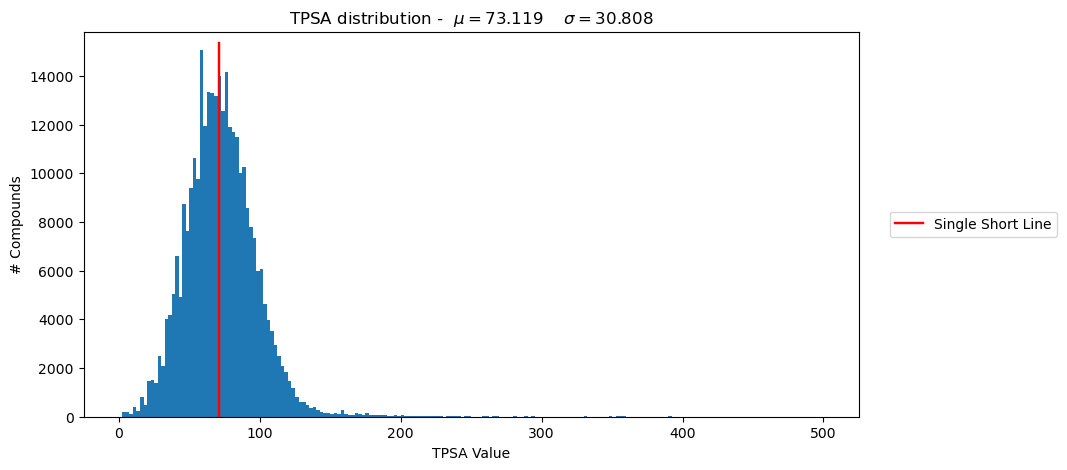

In [259]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
num_bins = 200
# fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,5))
sigma = df_train.Metadata_TPSA.std()
mu = df_train.Metadata_TPSA.mean()
med = df_train.Metadata_TPSA.median()
# the histogram of the data
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt.hist(df_train.Metadata_TPSA, num_bins, density=False, range=[0, 500],)
# p1 = [(med, 710), (6.0, 605)]
# _ = plt.vlines(x=med, ymin=10, ymax=17000, colors='red', linestyles='-', lw=1.75, label='Single Short Line')
_ = plt.axvline(x=med, ymin=0, ymax=.97, color='red', linestyle='-', lw=1.75, label='Single Short Line')
_ = plt.xlabel('TPSA Value');
_ = plt.ylabel('# Compounds');
_ = plt.title(fr'TPSA distribution -  $\mu={mu:.3f}$    $\sigma={sigma:.3f}$')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# axs[1].hist(dist2, bins=n_bins)
plt.show()

## Stratified CV data splits

In [260]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [261]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
# n_points = 100
# X = rng.randn(100, 10)

# percentiles_classes = [0.1, 0.3, 0.6]
# y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [ ]:
# Generate uneven groups

# group_prior = rng.dirichlet([2] * 10)
# group_prior.sum()
# group_prior

# groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
# groups.shape
# groups

In [ ]:
groups = np.repeat(0, train_X.shape[0])
groups.shape

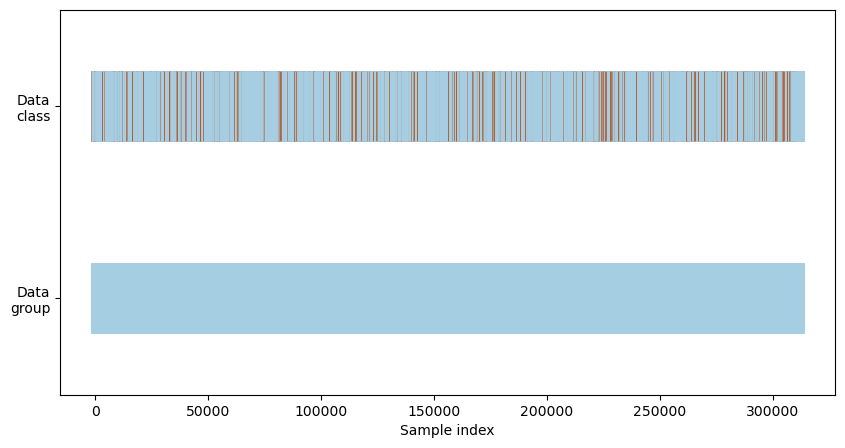

In [84]:
visualize_groups(train_y, groups, "no groups")

In [88]:
n_splits = 5
groups = None

/tmp/ipykernel_4107164/1298143750.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

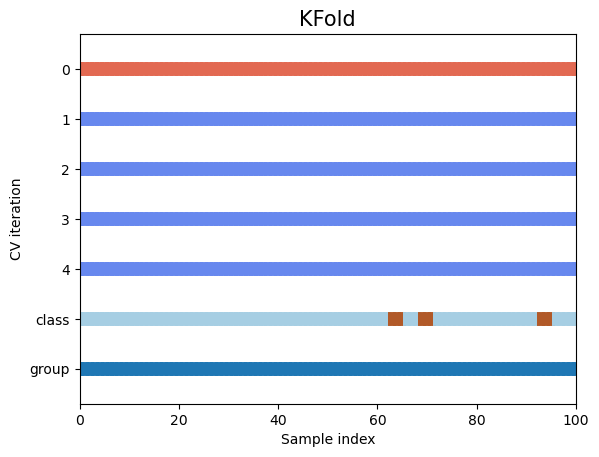

In [89]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, train_X, train_y, groups, ax, n_splits)

## Create balanced datasets

In [635]:
bal_train_X, bal_train_y = balance_datasets(train_X, train_y, ratio = 1)
bal_train_X_2, bal_train_y_2 = balance_datasets(train_X, train_y, ratio = 2)


 Take 12388 samples from total of 12388 negative training samples
 Take 12388 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 37164  Total len: 74328

 X :  Min: -27.6719    Max: 23.7271   Mean: 0.0016  Std: 1.0157
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 12388 samples from total of 12388 negative training samples
 Take 24776 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 74328  Total len: 111492

 X :  Min: -27.3326    Max: 26.3826   Mean: 0.0014  Std: 1.0076
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


In [636]:
bal_test_X, bal_test_y = balance_datasets(test_X, test_y, ratio = 1)
bal_test_X_2, bal_test_y_2 = balance_datasets(test_X, test_y, ratio = 2)


 Take 1388 samples from total of 1388 negative training samples
 Take 1388 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 4164  Total len: 8328

 X :  Min: -16.9431    Max: 19.0416   Mean: 0.0030  Std: 1.0028
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 1388 samples from total of 1388 negative training samples
 Take 2776 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 8328  Total len: 12492

 X :  Min: -18.7677    Max: 20.9524   Mean: 0.0015  Std: 0.9780
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


# Model definitions

# **[SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)**

Intuitively, the `gamma` parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The `gamma`parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The `C`parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words`C` behaves as a regularization parameter in the SVM.

In [626]:
svc = SVC(random_state =42, max_iter = 10000, tol = 1e-5, cache_size = 400, class_weight='balanced')

## Parameters

In [637]:
svm_grid_parameters_0 = [
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['linear']},
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['rbf']},
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'gamma': [100,10,1,1e-1,1e-2, 1e-3], 'kernel': ['rbf']},
 ]

# svm_grid_parameters_1 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel' : ['linear'] }
# svm_grid_parameters_1 = {'C': [1], 'gamma': [1e-1], 'kernel' : ['linear'] }

# svm_grid_parameters_2 = {'C': [1, 10], 'kernel': ['linear']}
# svm_grid_parameters_2 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel': ['rbf']}

# svm_grid_parameters_3 = { 'C': [1, 10, 100],'gamma': [10,1,1e-1,1e-2]}
# svm_grid_parameters_3 = { 'C': [1, 10, 100], 'kernel': ['rbf']}

# svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1, 1.0e-1, 1.0e-2, ]}
# svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1.0e-3, 1.0e-4, 1.0e-5, ]}
svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [1.0e-6, 1.0e-7, 1.0e-8,]}
svm_grid_parameters_3 = {'C': [0.1, 1, 10, 100, 200], 'kernel': ['rbf']}
svm_grid_parameters_3 = {'C': [100, 500, 1000], 'kernel': ['rbf']}

## Training

In [628]:
PARM_SET = svm_grid_parameters_3

In [638]:
NUM_JOBS = 5
X_DATA = bal_train_X
Y_DATA = bal_train_y

In [639]:
vt_svm = model_selection(svc, PARM_SET, X_DATA, Y_DATA, scoring = 'roc_auc', cv=4, GridSearch = True, n_jobs=NUM_JOBS,  verbose = 3)

 verbose is 3
 params_grid: {'C': [100, 500, 1000], 'kernel': ['rbf']}
 scoring    : roc_auc     cv:  4   n_jobs: 5   gridsearch: True    n_iter: 20   refit: True   
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/ptsnnl/l

[CV 4/4] END .................C=100, kernel=rbf;, score=0.542 total time= 4.9min
[CV 3/4] END .................C=500, kernel=rbf;, score=0.541 total time= 5.8min
[CV 1/4] END .................C=100, kernel=rbf;, score=0.545 total time= 5.0min
[CV 1/4] END ................C=1000, kernel=rbf;, score=0.529 total time= 5.8min
[CV 1/4] END .................C=500, kernel=rbf;, score=0.529 total time= 5.1min
[CV 2/4] END ................C=1000, kernel=rbf;, score=0.533 total time= 5.9min
[CV 3/4] END .................C=100, kernel=rbf;, score=0.528 total time= 4.7min
[CV 2/4] END .................C=500, kernel=rbf;, score=0.533 total time= 5.8min
[CV 3/4] END ................C=1000, kernel=rbf;, score=0.541 total time= 4.6min
[CV 2/4] END .................C=100, kernel=rbf;, score=0.529 total time= 4.9min
[CV 4/4] END .................C=500, kernel=rbf;, score=0.522 total time= 5.7min
[CV 4/4] END ................C=1000, kernel=rbf;, score=0.522 total time= 4.7min
Best parameters set found on

/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
# Best parameters set found on development set: {'C': 10, 'kernel': 'rbf'}
# Best score: 0.5378465362878473
# Grid scores on development set:

# 0.50235 (+/-0.031) for {'C': 1, 'kernel': 'rbf'}
# 0.53181 (+/-0.010) for {'C': 5, 'kernel': 'rbf'}
### 0.53785 (+/-0.008) for {'C': 10, 'kernel': 'rbf'}
### 0.53836 (+/-0.009) for {'C': 10, 'kernel': 'rbf'}
# 0.52558 (+/-0.010) for {'C': 15, 'kernel': 'rbf'}
# 0.51977 (+/-0.027) for {'C': 20, 'kernel': 'rbf'}
# 0.52734 (+/-0.028) for {'C': 25, 'kernel': 'rbf'}
# 0.53087 (+/-0.011) for {'C': 30, 'kernel': 'rbf'}
### 0.53761 (+/-0.014) for {'C': 30, 'kernel': 'rbf'}
# 0.53227 (+/-0.014) for {'C': 50, 'kernel': 'rbf'}
# 0.51949 (+/-0.011) for {'C': 70, 'kernel': 'rbf'}
# 0.53222 (+/-0.006) for {'C': 90, 'kernel': 'rbf'}
# 0.52077 (+/-0.022) for {'C': 100, 'kernel': 'rbf'}

# Best parameters set found on development set: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
# Best score: 0.5263117855594914
# Grid scores on development set:

# 0.48997 (+/-0.005) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
# 0.48441 (+/-0.002) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
# 0.52631 (+/-0.016) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
# 0.52721 (+/-0.007) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.53590 (+/-0.010) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.54687 (+/-0.011) for {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
# 0.54837 (+/-0.010) for {'C': 10, 'gamma': 1e-06, 'kernel': 'rbf'}
### 0.54872 (+/-0.011) for {'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'}
# 0.54796 (+/-0.012) for {'C': 10, 'gamma': 1e-08, 'kernel': 'rbf'}
 


In [640]:
vt_svm
vt_svm.best_estimator_
vt_svm.best_index_
vt_svm.best_params_
vt_svm.best_score_
vt_svm.classes_
vt_svm.cv
vt_svm.cv_results_
vt_svm.decision_function
vt_svm.error_score
vt_svm.estimator
vt_svm.fit
vt_svm.get_metadata_routing()
print('-'*40)
print(f"vt_svm parameters: ")
print('-'*40)
vt_svm.get_params()
# vt_svm.inverse_transform

GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

SVC(C=100, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)

0

{'C': 100, 'kernel': 'rbf'}

0.5360226792539031

array([0, 1], dtype=uint8)

4

{'mean_fit_time': array([205.12652862, 243.32209796, 225.83543795]),
 'std_fit_time': array([ 6.79211394, 18.80770631, 34.98232562]),
 'mean_score_time': array([88.93056607, 91.10064435, 88.03145939]),
 'std_score_time': array([1.21205485, 1.97996244, 3.45450594]),
 'param_C': masked_array(data=[100, 500, 1000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 100, 'kernel': 'rbf'},
  {'C': 500, 'kernel': 'rbf'},
  {'C': 1000, 'kernel': 'rbf'}],
 'split0_test_score': array([0.54505406, 0.52896171, 0.52896171]),
 'split1_test_score': array([0.52928611, 0.53277688, 0.53277688]),
 'split2_test_score': array([0.52812428, 0.5412952 , 0.5412952 ]),
 'split3_test_score': array([0.54162626, 0.52158292, 0.52158292]),
 'mean_test_score': array([0.53602268, 0.53115418, 0.53115418]),
 '

<bound method BaseSearchCV.decision_function of GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)>

nan

SVC(cache_size=400, class_weight='balanced', max_iter=10000, random_state=42,
    tol=1e-05)

<bound method BaseSearchCV.fit of GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)>

{'estimator': {'mapping': [{'callee': 'fit', 'caller': 'fit'}], 'router': {'fit': {'sample_weight': None}, 'score': {'sample_weight': None}}}, 'scorer': {'mapping': [{'callee': 'score', 'caller': 'score'}, {'callee': 'score', 'caller': 'fit'}], 'router': {}}, 'splitter': {'mapping': [{'callee': 'split', 'caller': 'fit'}], 'router': {}}}

----------------------------------------
vt_svm parameters: 
----------------------------------------


{'cv': 4,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 400,
 'estimator__class_weight': 'balanced',
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': 10000,
 'estimator__probability': False,
 'estimator__random_state': 42,
 'estimator__shrinking': True,
 'estimator__tol': 1e-05,
 'estimator__verbose': False,
 'estimator': SVC(cache_size=400, class_weight='balanced', max_iter=10000, random_state=42,
     tol=1e-05),
 'n_jobs': 5,
 'param_grid': {'C': [100, 500, 1000], 'kernel': ['rbf']},
 'pre_dispatch': 5,
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 3}

In [180]:
# vt_svm.multimetric_
# vt_svm.n_features_in_
# vt_svm.n_jobs
# vt_svm.n_splits_
# vt_svm.param_grid
# vt_svm.pre_dispatch
# vt_svm.predict
# vt_svm.predict_log_proba
# vt_svm.predict_proba
# vt_svm.refit
# vt_svm.refit_time_
# vt_svm.return_train_score
# vt_svm.score
# vt_svm.score_samples
# vt_svm.scorer_
# vt_svm.scoring
# vt_svm.transform
# vt_svm.verbose

### Persist Model

In [641]:
FILENAME = 'SVM_estimators_SNNL_1_BALANCED_RATIO_1.pkl'

In [642]:
save_to_pickle(vt_svm, '', FILENAME, verbose = True)

 save_to_pickle(): save data to SVM_estimators_SNNL_1_BALANCED_RATIO_1.pkl


### Load Model

In [447]:
svm_estimators = load_from_pickle('', FILENAME)

In [448]:
svm_estimators
print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print()
print(f"best_estimator_  :   {svm_estimators.best_estimator_}")
# print(f"best_index_  :       {svm_estimators.best_index_}")
# print(f"best_params_ :       {svm_estimators.best_params_}")
# print(f"best_score_  :       {svm_estimators.best_score_}")
# print(f"classes_     :       {svm_estimators.classes_}")
# print(f"cv           :       {svm_estimators.cv}")
# print()
# print(f"cv_results_  :       {svm_estimators.cv_results_}")
# print()
# print(f"error_score  :       {svm_estimators.error_score}")
# print(f"estimator    :       {svm_estimators.estimator}")

GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100, 200], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

parameters   :

best_estimator_  :   SVC(C=0.1, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)


## Metrics - `svm_estimators_1`

In [644]:
FILENAME = 'SVM_estimators_SNNL_1_BALANCED_RATIO_1.pkl'

svm_estimators = load_from_pickle('', FILENAME)

In [645]:
# print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print(f"best_estimator_  :   {svm_estimators.best_estimator_}")
print()
 

best_estimator_  :   SVC(C=100, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)



In [646]:
TEST_X, TEST_Y = bal_test_X, bal_test_y

In [647]:
y_pred = svm_estimators.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [648]:
bal_y_pred = svm_estimators.best_estimator_.predict(bal_test_X)
bal_y_pred.shape

(8328,)

In [657]:
label_counts( [("Ground Truth", test_y), ("Predictions", y_pred), ("Balanced Ground Truth", bal_test_y), ("Balanced Predictions", bal_test_y)])


 Ground Truth
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples: 34542
 Label 0:  24,179      % 70.00 
 Label 1:  10,363      % 30.00 

 Balanced Ground Truth
 Total samples: 8328
 Label 0:   4,164      % 50.00 
 Label 1:   4,164      % 50.00 

 Balanced Predictions
 Total samples: 8328
 Label 0:   4,164      % 50.00 
 Label 1:   4,164      % 50.00 



In [660]:
compute_metrics(test_y, y_pred, "Original test file")

 Original test file 
 ------------------ 
 Accuracy: 0.65998     Precision: 0.13423     Recall: 0.33405     F1: 0.19151 

 True + labels:          4164     ratio to total:  0.12055
 Predicted + labels:    10363     ratio to total:  0.30001
 True/Predicted Match:  22797     ratio to total:  0.65998


In [661]:
compute_metrics(bal_test_y, bal_y_pred, " 1:1 Balanced test file")

  1:1 Balanced test file 
 ----------------------- 
 Accuracy: 0.51393     Precision: 0.52176     Recall: 0.33405     F1: 0.40732 

 True + labels:          4164     ratio to total:  0.50000
 Predicted + labels:     2666     ratio to total:  0.32012
 True/Predicted Match:   4280     ratio to total:  0.51393


In [662]:
# plots_from_estimator(svm_estimators.best_estimator_, test_X, y_pred)
# plots_from_estimator(svm_estimators.best_estimator_, bal_test_X, bal_y_pred)

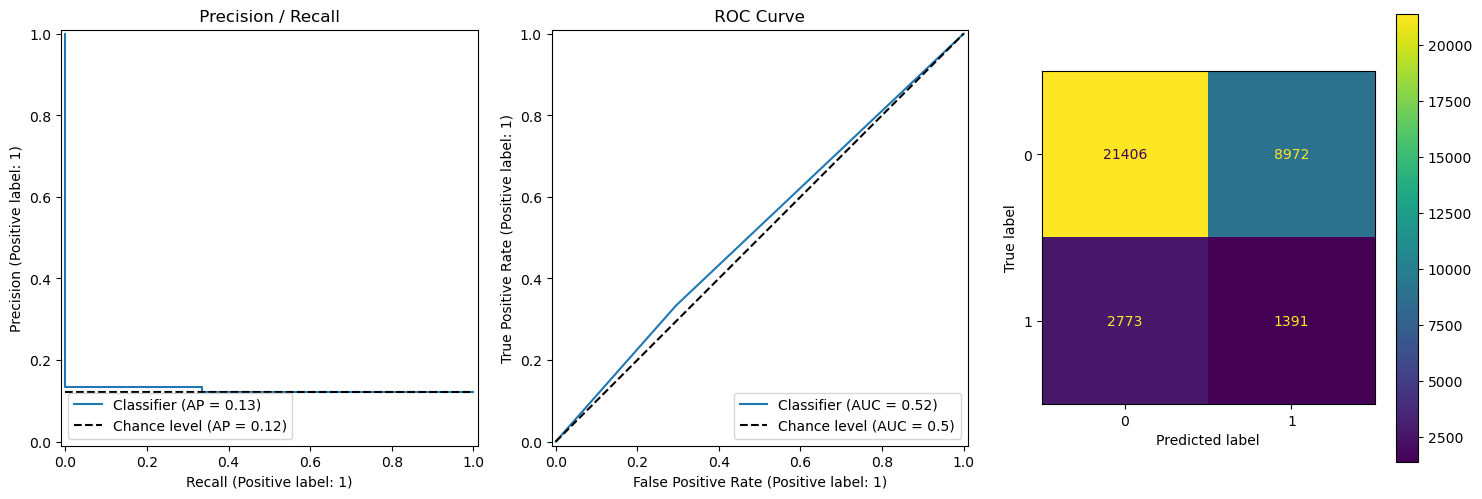

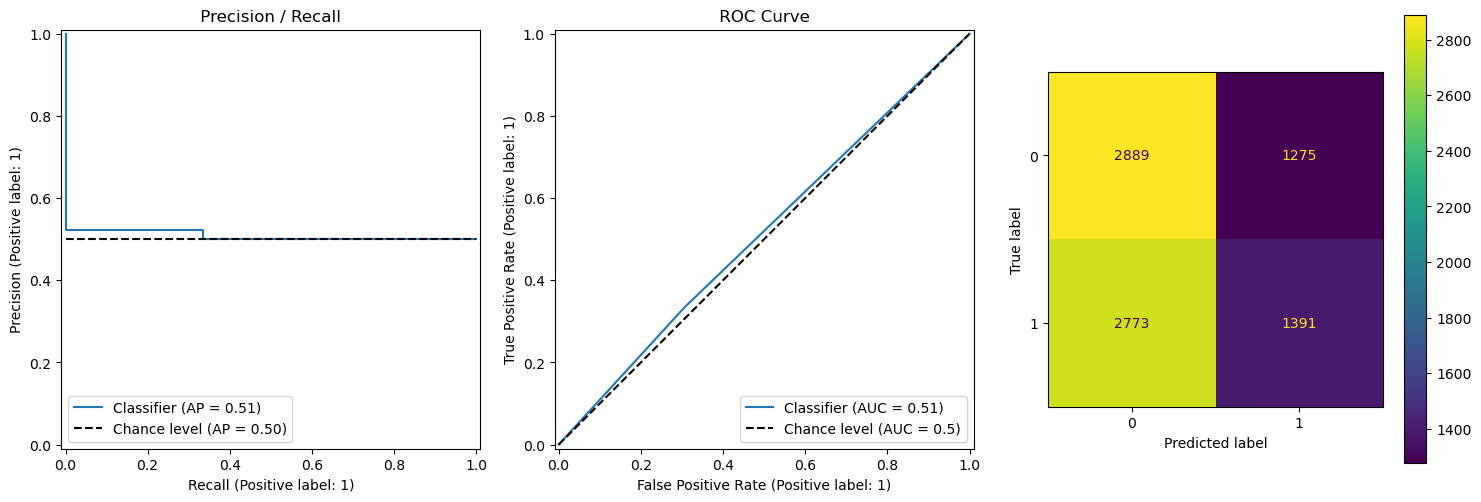

In [663]:
plots_from_predictions(test_y, y_pred)
plots_from_predictions(bal_test_y, bal_y_pred)

# **[kNN](https://scikit-learn.org/stable/modules/neighbors.html)** 

* **algorithm**  {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
Algorithm used to compute the nearest neighbors:

    `ball_tree` will use BallTree
  
    `kd_tree` will use KDTree

    `brute` will use a brute-force search.

    `auto` will attempt to decide the most appropriate algorithm based on the values passed to fit method.

    Note: fitting on sparse input will override the setting of this parameter, using brute force.

*  **leaf_size** int, default=30  -- Leaf size passed to BallTree or KDTree.

      This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

*  **p**   float, default=2 -- Power parameter for the Minkowski metric.

      When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used. This parameter is expected to be positive.


*  **metric**  str or callable, default=’minkowski’ -- Metric to use for distance computation.

      Default is `minkowski`, which results in the standard Euclidean distance when p = 2. See the documentation of scipy.spatial.distance and the metrics listed in distance_metrics for valid metric values.

      If metric is `precomputed`, X is assumed to be a distance matrix and must be square during fit. X may be a sparse graph, in which case only “nonzero” elements may be considered neighbors. 

      If metric is a callable function, it takes two arrays representing 1D vectors as inputs and must return one value indicating the distance between those vectors. This works for Scipy’s metrics, but is less efficient than passing the metric name as a string.

*  **metric_params**   dict, default=None -- Additional keyword arguments for the metric function.

*  **n_jobs**  int, default=None -- The number of parallel jobs to run for neighbors search.

    None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. Doesn’t affect fit method.   

In [166]:
# del knn_clf, knn_estimators, knn_grid_parameters_des, knn_grid_parameters_fp, knn_grid_parameters_fpcounts

In [26]:
# classification

knn_clf = KNeighborsClassifier()

## Parameters

In [85]:
knn_grid_parameters = {'n_neighbors': [3, 6, 9, 15, 19, 25, 35, 45, 55, 71],
                       'weights': ['distance'],
                       'p': [1,2]}

knn_grid_parameters = {'n_neighbors': [5, 9, 15, 19, 23, 25, 35, 45, 55, 71],
                       'weights': ['distance'],
                       'metric' : ['jaccard', 'dice', 'rogerstanimoto']}

knn_grid_parameters = {'n_neighbors': [5, 9, 15, 19, 25, 35, 45, 55, 71],
                       'weights': ['distance'],
                       'metric' : ['hamming', 'canberra', 'braycurtis']}

knn_grid_parameters = {'n_neighbors': [57],
                       'weights': ['distance'],
                       'metric' : ['jaccard', 'dice', 'rogerstanimoto', 'hamming', 'canberra', 'braycurtis']}

# knn_grid_parameters_des = {'n_neighbors': [3, 6, 9, 12, 15], 'weights': ['distance'], 'p': [1]}
knn_grid_parameters = {'n_neighbors': [105, 120,  135, 150 ],
                       'weights': ['distance'],
                       'metric' : ['minkowski'],'p': [2]}


In [86]:
%%time
## returns :  a: labeled_features, b: ublabeled_features, c: labeled_Y, d: df_labled.indicies, e: df_unlabeled.indicies
# a,b,c,d,e = prepare_input(train_labels, train_ecfp6_bits, target = 'verytoxic', encoder = encoder_verytoxic)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


## Training

In [87]:
# PARM_SET = knn_grid_parameters_des
PARM_SET = knn_grid_parameters

In [104]:
print(PARM_SET)

{'n_neighbors': [105, 120, 135, 150], 'weights': ['distance'], 'metric': ['minkowski'], 'p': [2]}


In [106]:
NUM_JOBS = 4

In [107]:
vt_knn_ecfp6bits = model_selection(knn_clf, PARM_SET, train_X, train_y, scoring='roc_auc',
                                   cv=5, GridSearch=True, n_jobs=NUM_JOBS, verbose=4)

 verbose is 4
 params_grid: {'n_neighbors': [105, 120, 135, 150], 'weights': ['distance'], 'metric': ['minkowski'], 'p': [2]}
 scoring    : roc_auc     cv:  5   n_jobs: 4   gridsearch: True    n_iter: 20   refit: True   
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters set found on development set: {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
Best score: 0.5878363154701123
Grid scores on development set:

0.58720 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 105, 'p': 2, 'weights': 'distance'}
0.58766 (+/-0.015) for {'metric': 'minkowski', 'n_neighbors': 120, 'p': 2, 'weights': 'distance'}
0.58784 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
0.58775 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 150, 'p': 2, 'weights': 'distance'}


In [ ]:

# 0.53766 (+/-0.007) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
# 0.54873 (+/-0.008) for {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
# 0.55621 (+/-0.007) for {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
# 0.56121 (+/-0.008) for {'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
# 0.56505 (+/-0.010) for {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
# 0.57179 (+/-0.011) for {'n_neighbors': 24, 'p': 1, 'weights': 'distance'}
# 0.57694 (+/-0.012) for {'n_neighbors': 32, 'p': 1, 'weights': 'distance'}
# 0.57842 (+/-0.013) for {'n_neighbors': 36, 'p': 1, 'weights': 'distance'}
# 0.57964 (+/-0.013) for {'n_neighbors': 42, 'p': 1, 'weights': 'distance'}
# 0.58258 (+/-0.012) for {'n_neighbors': 57, 'p': 1, 'weights': 'distance'}
# 0.58379 (+/-0.011) for {'metric': 'minkowski', 'n_neighbors': 57, 'p': 2, 'weights': 'distance'}
# 0.58498 (+/-0.012) for {'metric': 'minkowski', 'n_neighbors': 69, 'p': 2, 'weights': 'distance'}
# 0.58603 (+/-0.013) for {'metric': 'minkowski', 'n_neighbors': 81, 'p': 2, 'weights': 'distance'}
# 0.58645 (+/-0.013) for {'metric': 'minkowski', 'n_neighbors': 90, 'p': 2, 'weights': 'distance'}
# 0.58720 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 105, 'p': 2, 'weights': 'distance'}
# 0.58766 (+/-0.015) for {'metric': 'minkowski', 'n_neighbors': 120, 'p': 2, 'weights': 'distance'}
# 0.58784 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
# 0.58775 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 150, 'p': 2, 'weights': 'distance'}

In [140]:
vt_knn_ecfp6bits
print(f"parameters   :")
pp.pprint(vt_knn_ecfp6bits.get_params())

print(f"best_estimator_  :   {vt_knn_ecfp6bits.best_estimator_}")
print(f"best_index_  :       {vt_knn_ecfp6bits.best_index_}")
print(f"best_params_ :       {vt_knn_ecfp6bits.best_params_}")
print(f"best_score_  :       {vt_knn_ecfp6bits.best_score_}")
print(f"classes_     :       {vt_knn_ecfp6bits.classes_}")
print(f"cv           :       {vt_knn_ecfp6bits.cv}")
print()
print(f"cv_results_  :       {vt_knn_ecfp6bits.cv_results_}")
print()
print(f"error_score  :       {vt_knn_ecfp6bits.error_score}")
print(f"estimator    :       {vt_knn_ecfp6bits.estimator}")

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [105, 120, 135, 150], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=4)

parameters   :
{   'cv': 5,
    'error_score': nan,
    'estimator': KNeighborsClassifier(),
    'estimator__algorithm': 'auto',
    'estimator__leaf_size': 30,
    'estimator__metric': 'minkowski',
    'estimator__metric_params': None,
    'estimator__n_jobs': None,
    'estimator__n_neighbors': 5,
    'estimator__p': 2,
    'estimator__weights': 'uniform',
    'n_jobs': 4,
    'param_grid': {   'metric': ['minkowski'],
                      'n_neighbors': [105, 120, 135, 150],
                      'p': [2],
                      'weights': ['distance']},
    'pre_dispatch': '2*n_jobs',
    'refit': True,
    'return_train_score': False,
    'scoring': 'roc_auc',
    'verbose': 4}
best_estimator_  :   KNeighborsClassifier(n_neighbors=135, weights='distance')
best_index_  :       2
best_params_ :       {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
best_score_  :       0.5878363154701123
classes_     :       [0. 1.]
cv           :       5

cv_results_  :   

In [83]:
bcnt = np.bincount(test_y.astype(np.int64))
print(f"{bcnt[0]/bcnt.sum():4f}")

0.879451


In [112]:
y_pred = vt_knn_ecfp6bits.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [163]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f"Test Accuracy: {test_accuracy:4f}")
print(f"Precision: {precision:.5f}   Recall: {recall:.5f}   F1: {f1:.5f} "
      f"  True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}  "
      f"Match: {(y_pred == test_y).sum()}   {(y_pred == test_y).sum()/test_y.shape[0]:.6f}" )

Test Accuracy: 0.879567
Precision: 0.70000   Recall: 0.00168   F1: 0.00335   True + labels: 4164.0  Predicted + labels: 10.0  Match: 30382   0.879567


### Persist Model

In [142]:
FILENAME = 'KNN_estimators_2.pkl'

In [143]:
save_to_pickle(vt_knn_ecfp6bits, '', FILENAME, verbose = True)

 save_to_pickle(): save data to KNN_estimators_2.pkl


### Load Model

In [142]:
FILENAME = 'KNN_estimators_2.pkl'

In [144]:
knn_estimators = load_from_pickle('', FILENAME)

In [165]:
knn_estimators
print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [57, 69, 81, 90], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=1)

parameters   :
{   'cv': 5,
    'error_score': nan,
    'estimator': KNeighborsClassifier(),
    'estimator__algorithm': 'auto',
    'estimator__leaf_size': 30,
    'estimator__metric': 'minkowski',
    'estimator__metric_params': None,
    'estimator__n_jobs': None,
    'estimator__n_neighbors': 5,
    'estimator__p': 2,
    'estimator__weights': 'uniform',
    'n_jobs': 4,
    'param_grid': {   'metric': ['minkowski'],
                      'n_neighbors': [57, 69, 81, 90],
                      'p': [2],
                      'weights': ['distance']},
    'pre_dispatch': '2*n_jobs',
    'refit': True,
    'return_train_score': False,
    'scoring': 'roc_auc',
    'verbose': 1}

best_estimator_  :   KNeighborsClassifier(n_neighbors=90, weights='distance')


## Metrics - `KNN_estimators_1`

In [303]:
FILENAME = 'KNN_estimators_1.pkl'

In [304]:
knn_estimators = load_from_pickle('', FILENAME)
knn_estimators
# print(f"parameters   :")
# pp.pprint(knn_estimators.get_params())
# print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")
 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [57, 69, 81, 90], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=1)

best_estimator_  :   KNeighborsClassifier(n_neighbors=90, weights='distance')


In [307]:
y_pred = knn_estimators.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [309]:
for grp_name, labels in [("Ground Truth", test_y), ("Predictions", y_pred)]:
    bcnt = np.bincount(labels.astype(np.int64))
    print(f" {grp_name}")
    print(f" Total samples: {bcnt.sum():7,d}")
    print(f" Label 0: {bcnt[0]:7,d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
    print(f" Label 1: {bcnt[1]:7,d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
    print("")

 Ground Truth
 Total samples:  34,542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples:  34,542
 Label 0:  34,532      % 99.97 
 Label 1:      10      % 0.03 



In [311]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f" Test Accuracy: {test_accuracy:4f}")
print(f" Precision: {precision:.5f}     Recall: {recall:.5f}     F1: {f1:.5f} "
      f"\n True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}     Match: {(y_pred == test_y).sum()} " )

 Test Accuracy: 0.879567
 Precision: 0.70000     Recall: 0.00168     F1: 0.00335 
 True + labels: 4164.0  Predicted + labels: 10.0     Match: 30382 


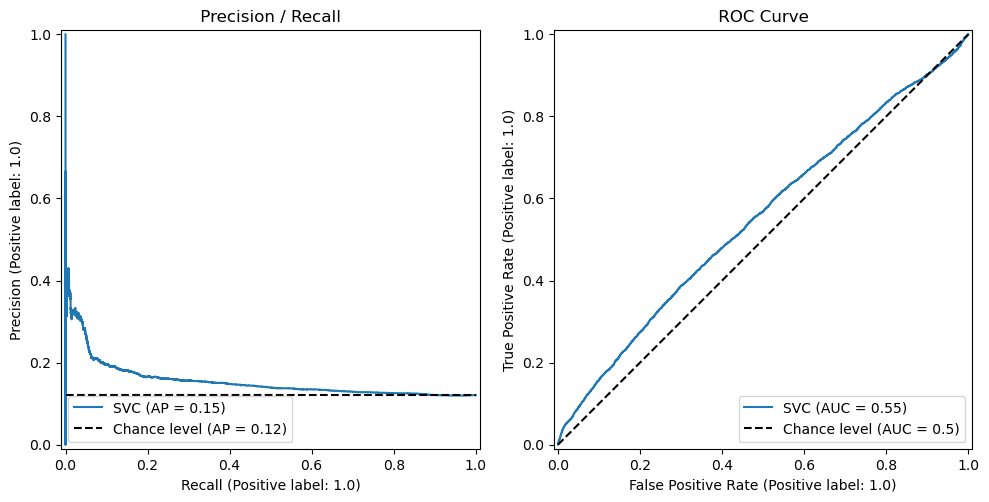

In [313]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

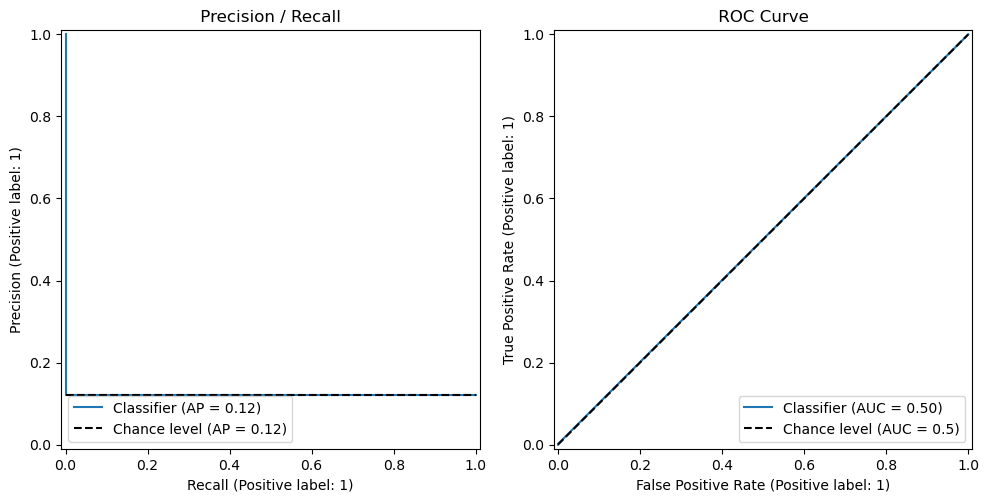

In [314]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_predictions(test_y, y_pred, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_predictions(test_y, y_pred, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

## Metrics - `KNN_estimators_2`

In [315]:
FILENAME = 'KNN_estimators_2.pkl'

In [316]:
knn_estimators = load_from_pickle('', FILENAME)
knn_estimators
# print(f"parameters   :")
# pp.pprint(knn_estimators.get_params())
# print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")
 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [105, 120, 135, 150], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=4)

best_estimator_  :   KNeighborsClassifier(n_neighbors=135, weights='distance')


In [317]:
y_pred = knn_estimators.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [318]:
for grp_name, labels in [("Ground Truth", test_y), ("Predictions", y_pred)]:
    bcnt = np.bincount(labels.astype(np.int64))
    print(f" {grp_name}")
    print(f" Total samples: {bcnt.sum():7,d}")
    print(f" Label 0: {bcnt[0]:7,d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
    print(f" Label 1: {bcnt[1]:7,d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
    print("")

 Ground Truth
 Total samples:  34,542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples:  34,542
 Label 0:  34,534      % 99.98 
 Label 1:       8      % 0.02 



In [320]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f" Test Accuracy: {test_accuracy:4f}")
print(f" Precision: {precision:.5f}     Recall: {recall:.5f}     F1: {f1:.5f} "
      f"\n True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}     Match: {(y_pred == test_y).sum()} " )

 Test Accuracy: 0.879625
 Precision: 0.87500     Recall: 0.00168     F1: 0.00336 
 True + labels: 4164.0  Predicted + labels: 8.0     Match: 30384 


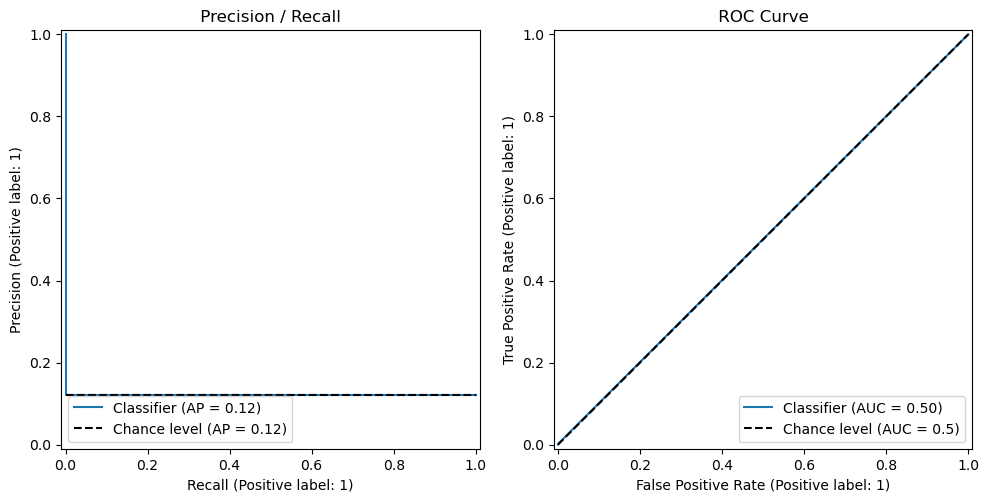

In [321]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_predictions(test_y, y_pred, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_predictions(test_y, y_pred, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

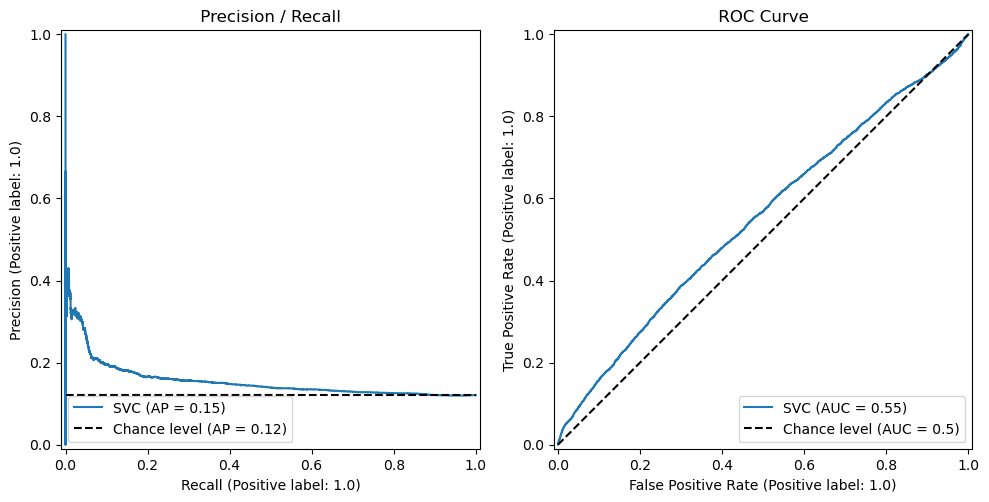

In [322]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()